In [1]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import random
import torch
import transformers
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
doordash_train = pd.read_csv("../datasets/doordash/all_train.csv")
doordash_test = pd.read_csv("../datasets/doordash/all_test.csv")
doordash_all = pd.concat([doordash_train, doordash_test]).reset_index()

doordash_all

,index,Business,Name,L1,L2,L1 ID,L2 ID
0,0,Cub Foods,"equaline gas relief, infants', 20 mg, dye free...",Medicine,Digestive,medicine,digestive
1,1,Cub Foods,baby basics cotton swabs (100 ct),Personal Care,Ear Care,personal_care,ear_care
2,2,Cub Foods,infants' mylicon gas relief dye free drops (1 oz),Medicine,Digestive,medicine,digestive
3,3,Cub Foods,"equaline infants' ibuprofen oral suspension, b...",Medicine,Pain Reliever,medicine,pain_reliever
4,4,Cub Foods,orajel sesame street fruity fun tooth & gum cl...,Personal Care,Oral Health,personal_care,oral_health
...,...,...,...,...,...,...,...
95592,11402,Kroger,lala wild strawberry flavored probiotic yogurt...,Dairy & Eggs,Yogurt,dairy_and_eggs,yogurt
95593,11403,Kroger,chobani flip s'more s'mores low-fat greek yogu...,Dairy & Eggs,Yogurt,dairy_and_eggs,yogurt
95594,11404,Kroger,kroger strawberry fruit on the bottom lowfat y...,Dairy & Eggs,Yogurt,dairy_and_eggs,yogurt
95595,11405,Kroger,the greek gods honey vanilla greek style yogur...,Dairy & Eggs,Yogurt,dairy_and_eggs,yogurt


In [32]:
google_train = pd.read_csv("../datasets/google/all_train.csv")
google_test = pd.read_csv("../datasets/google/all_train.csv")
google_all = pd.concat([google_train, google_test]).reset_index().drop(columns=["index"])

google_all

,Business,Name,L1,L2,L1 ID,L2 ID
0,Chewy.com,Tiki Cat Born Carnivore Chicken Luau Dry Cat F...,Pet Care,Cat Food,pet_care,cat_food
1,nearby at Grainger Industrial Supply,Sqwincher Qwik Stik Grape S4832799,Drinks,Energy,drinks,energy
2,eBay,"INEVIFIT Bathroom Scale, Highly Accurate Digit...",Personal Care,Home Diagnostics,personal_care,home_diagnostics
3,Chewy.com,Pets First Los Angeles Rams Pet T-Shirt - X-Large,Pet Care,Pet Accessories,pet_care,pet_accessories
4,Chewy.com,Evangers Super Premium Hand-Packed Whole Chick...,Pet Care,Dog Food,pet_care,dog_food
...,...,...,...,...,...,...
359503,UnbeatableSale,"Joy Dishwashing Liquid, 38 oz Bottle, 8/Carton",Household,Cleaning,household,cleaning
359504,Natural Healthy Concepts,Bach Rescue Remedy Pet - 10 ml,Pet Care,Cat Food,pet_care,cat_food
359505,Walmart - The Homebrew Shop,Homebrew The Grainfather Grainstopper,Personal Care,Beauty Tools,personal_care,beauty_tools
359506,Bonanza - Gifts & Decore,Lady Primrose Celadon Extract Deluxe Body Brus...,Household,Cleaning,household,cleaning


## L1 class frequencies

By Percentage Frequency

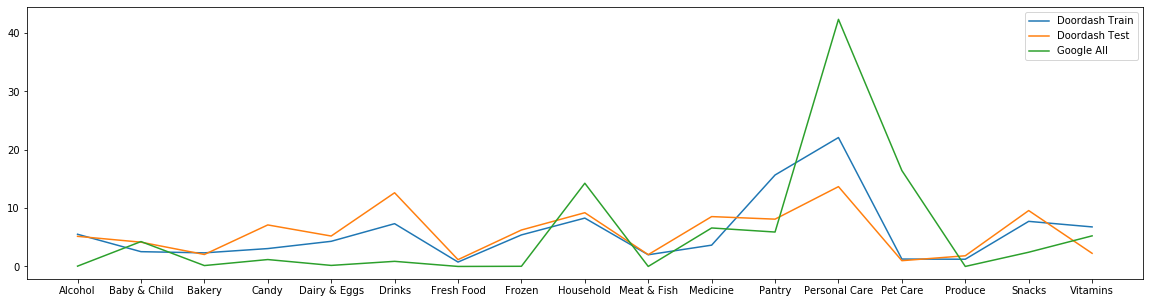

In [34]:
counts = pd.DataFrame({
    "Doordash Train": doordash_train.L1.value_counts() * 100 / len(doordash_train),
    "Doordash Test": doordash_test.L1.value_counts() * 100 / len(doordash_test),
    "Google All": google_all.L1.value_counts() * 100 / len(google_all)
})

plot = counts.plot(y=["Doordash Train", "Doordash Test", "Google All"], figsize=(20, 5))
plot.set_xticks(range(len(counts)))
plot.set_xticklabels(list(counts.index))
plot

Absolute number of samples

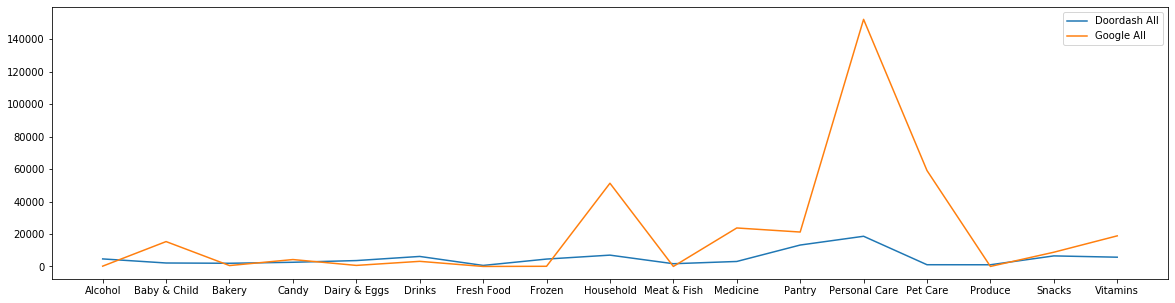

In [37]:
counts = pd.DataFrame({
    "Doordash All": doordash_train.L1.value_counts(),
    "Google All": google_all.L1.value_counts()
})

plot = counts.plot(y=["Doordash All", "Google All"], figsize=(20, 5))
plot.set_xticks(range(len(counts)))
plot.set_xticklabels(list(counts.index))
plot

## L2 Class Frequencies

In [138]:
# samples per L2 class
class_data = pd.DataFrame({
    "Doordash Train": doordash_train.groupby(["L1 ID", "L2 ID"]).size(), 
    "Doordash Test": doordash_test.groupby(["L1 ID", "L2 ID"]).size(), 
    "Google All": google_all.groupby(["L1 ID", "L2 ID"]).size() 
})

pd.options.display.float_format = '{:,.0f}'.format

print(class_data.sort_values('Doordash Train', ascending=False).to_string())

pd.reset_option('^display.', silent=True)

                                      Doordash Train  Doordash Test  Google All
L1 ID          L2 ID                                                           
personal_care  makeup                          5,694             55      30,756
               hair_care                       3,035            120      21,920
vitamins       supplements                     2,257             97      16,610
alcohol        wine                            2,199            105          60
personal_care  facial_care                     1,759             80      14,268
alcohol        beer                            1,516            357          40
household      cleaning                        1,444            169      19,786
snacks         chips                           1,378            261         754
candy          chocolate                       1,331            435         840
personal_care  bath_and_body                   1,311            138       8,112
drinks         juice                    

## Predictions

For every L1 and L2 category, we need to extract two scores: (train doordash --> test doordash) and (train doordash + google --> test doordash)

In [97]:
doordash_accs = {}  # key = (l1, l2) value = acc
doordash_google_accs = {}  # key = (l1, l2) value = acc

In [133]:
import os

# key = category id, value = data frame
predictions = {}  

for filename in os.listdir("../preds"):
    category_id = filename[:-4]  # strip .csv
    filepath = os.path.join("../preds", filename)
    
    # store (category id, predictions)
    predictions[category_id] = pd.read_csv(filepath)

In [134]:
# Given predictions, calculate the accuracy per sub-category
def get_accuracies(category_id, preds):
    scores = preds["Pred"] == preds["Category ID"]
    accs = scores.groupby(preds["Category ID"]).mean()
    
    for subcategory_id, acc in zip(list(accs.index), list(accs)):
        doordash_google_accs[(category_id, subcategory_id)] = [acc]

In [135]:
for category_id, preds in predictions.items():
    get_accuracies(category_id, preds)

In [136]:
weak_supervision_accuracies = pd.DataFrame(index=pd.MultiIndex.from_tuples(doordash_google_accs.keys()), columns=["Accuracy"])

for (l1_id, l2_id), acc in doordash_google_accs.items():
    weak_supervision_accuracies.loc[l1_id, l2_id] = acc

weak_supervision_accuracies

Accuracy
pet_care cat_food             0.823529
         cat_treats                0.5
         dog_food             0.823529
         dog_treats              0.625
         dog_treats_and_toys  0.307692
...                                ...
drinks   soda                 0.967213
         sparkling_water      0.695312
         sports               0.732877
         still_water          0.884393
         tea                  0.792793

[216 rows x 1 columns]

In [140]:
class_data["Weak Supervision Accuracy"] = weak_supervision_accuracies
print(class_data.sort_values('Doordash Train', ascending=False).to_string())

                                      Doordash Train  Doordash Test  Google All Weak Supervision Accuracy
L1 ID          L2 ID                                                                                     
personal_care  makeup                         5694.0           55.0     30756.0                  0.981818
               hair_care                      3035.0          120.0     21920.0                      0.95
vitamins       supplements                    2257.0           97.0     16610.0                  0.701031
alcohol        wine                           2199.0          105.0        60.0                  0.971429
personal_care  facial_care                    1759.0           80.0     14268.0                    0.8375
alcohol        beer                           1516.0          357.0        40.0                  0.941176
household      cleaning                       1444.0          169.0     19786.0                  0.940828
snacks         chips                          

In [141]:
# A view with L1's staying intact to quickly view groups.
print(class_data.sort_values(['L1 ID', 'Doordash Train'], ascending=False).to_string())

                                      Doordash Train  Doordash Test  Google All Weak Supervision Accuracy
L1 ID          L2 ID                                                                                     
vitamins       supplements                    2257.0           97.0     16610.0                  0.701031
               vitamins_a-z                    924.0          127.0      1044.0                  0.669291
               multivitamins                   734.0           11.0       902.0                  0.636364
               homeopathy_and_immune           687.0            5.0         NaN                       0.6
               aromatherapy                    585.0            NaN       304.0                       NaN
               minerals                        299.0            NaN         NaN                       NaN
               childrens_health                221.0           17.0         NaN                  0.823529
snacks         chips                          